In [1]:
import sys
import copy
import random
import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse import coo_matrix
import scipy as scipy
import math
from time import gmtime, strftime
import cProfile
import timeit
import scipy.sparse as sps
import warnings
from scipy.sparse import SparseEfficiencyWarning
warnings.simplefilter('ignore', SparseEfficiencyWarning)
import numpy as np
import gzip
from scipy.sparse import csr_matrix
from scipy.sparse import coo_matrix
from time import gmtime, strftime
import gzip
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr
import matplotlib
import matplotlib.patches as patches
import math
from scipy.stats.mstats import mquantiles
from random import randint
from sklearn.metrics.cluster import adjusted_rand_score
from scipy import stats
from matplotlib import cm
import pandas as pd
import math
import scipy
import collections
import sys
import gzip
import numpy as np
import os
import re
import gzip
from scipy.sparse import csr_matrix
from scipy.sparse import coo_matrix
from time import gmtime, strftime
import matplotlib.pyplot as plt
import scipy.sparse as sps
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator
from matplotlib import rc
from matplotlib import rcParams
from numpy import linalg as LA
%matplotlib inline

In [6]:
def read_nodes_from_bed(bedfile,blacklistfile='NA'):
    
    blacklist={}
    if blacklistfile!='NA':
        for line in gzip.open(blacklistfile):
            items=line.strip().split('\t')
            chromo,start,end=items[0],int(items[1]),int(items[2])
            if chromo not in blacklist:
                blacklist[chromo]=[]
            blacklist[chromo].append((start,end))
    
    #print "GenomeDISCO | "+strftime("%c")+" | processing: Loading genomic regions from "+bedfile

    nodes={}
    nodes_idx={}
    node_c=0
    blacklisted_nodes=[]
    for line in gzip.open(bedfile,'r'):
        items=line.strip().split('\t')
        chromo=items[0]
        start=int(items[1])
        end=int(items[2])
                
        node=items[3]
        if len(items)>4:
            include=items[4]
        
        if node in nodes.keys():
            #print "GenomeDISCO | "+strftime("%c")+" | Error: Genomic region appears multiple times in your file. One such example is "+node+". Please make sure all genomic regions are unique and re-run"
            sys.exit()
        if node not in nodes.keys():
            nodes[node]={}
            nodes[node]['idx']=node_c
            nodes[node]['chr']=chromo
            nodes[node]['start']=start
            nodes[node]['end']=end
            if len(items)>4:
                nodes[node]['include']=include
            nodes_idx[node_c]=node 
            
            if chromo in blacklist:
                for blacklist_item in blacklist[chromo]:
                    if (start<=blacklist_item[0] and end>=blacklist_item[0]) or (start<=blacklist_item[1] and end>=blacklist_item[1]) or (start>=blacklist_item[0] and end<=blacklist_item[1]):
                        blacklisted_nodes.append(node_c)
                
            node_c+=1
            
    return nodes,nodes_idx,blacklisted_nodes

def filter_nodes(m,to_remove):
    
    if len(to_remove)==0:
        return m
    
    nonzeros=m.nonzero()
    num_elts=len(nonzeros[0])
    
    r_idx=[i for i, x in enumerate(nonzeros[0]) if x not in to_remove]
    c_idx=[i for i, x in enumerate(nonzeros[1]) if x not in to_remove]
    keep=list(set(r_idx).union(set(c_idx)))
    
    coo_mat=m.tocoo()
        
    return csr_matrix((coo_mat.data[keep],(coo_mat.row[keep],coo_mat.col[keep])),shape=m.get_shape(),dtype=float) 
    

def construct_csr_matrix_from_data_and_nodes(f,nodes,blacklisted_nodes,remove_diag=True):
    #print "GenomeDISCO | "+strftime("%c")+" | processing: Loading interaction data from "+f

    total_nodes=len(nodes.keys())
    i=[]
    j=[]
    v=[]

    #print strftime("%c")
    c=0
    for line in gzip.open(f):
        items=line.strip().split('\t')
        n1,n2,val=nodes[items[0]]['idx'],nodes[items[1]]['idx'],float(items[2])
        mini=min(n1,n2)
        maxi=max(n1,n2)
        i.append(mini)
        j.append(maxi)
        v.append(val)
        c+=1

    csr_m=csr_matrix( (v,(i,j)), shape=(total_nodes,total_nodes),dtype=float)
    if remove_diag:
        csr_m.setdiag(0)
    return filter_nodes(csr_m,blacklisted_nodes)

def sqrtvc(m):
    mup=m
    mdown=mup.transpose()
    mdown.setdiag(0)
    mtogether=mup+mdown
    sums_sq=np.sqrt(mtogether.sum(axis=1)) 
    #make the ones that are 0, so that we don't divide by 0
    sums_sq[sums_sq==0.0]=1.0
    D_sq = sps.spdiags(1.0/sums_sq.flatten(), [0], mtogether.get_shape()[0], mtogether.get_shape()[1], format='csr')
    return sps.triu(D_sq.dot(mtogether.dot(D_sq)))

In [7]:
def plot_hic_matrices(ms,resolution,nticks,figwidth,figheight,x,add_to_start,desired_title,vmin,vmax,cmap,where_colorbar):

    #set ticks
    nnodes=ms[0].shape[0]
    stepsize=int(1.0*nnodes/nticks)
    start=0
    ticklist=[]
    ticknames=[]
    while start<=nnodes:
        ticklist.append(start)
        ticknames.append(str(1.0*(add_to_start*resolution+start*resolution))+' Mb')
        start+=stepsize

    colorbar_ticks=[vmin,0,vmax]
    if vmin==0:
        colorbar_ticks=[0,vmax]
    fig, plots = plt.subplots(1,len(ms))
    fig.set_size_inches(figwidth,figheight)
    fig.suptitle(desired_title, fontsize=20)
    for f in range(len(ms)):
        im1 = plots[f].matshow(ms[f],vmin=vmin,vmax=vmax,cmap=cmap)
        # Create divider for existing axes instance
        divider = make_axes_locatable(plots[f])
        if where_colorbar=='horizontal':
            cax = divider.append_axes("bottom", size="10%", pad=0.5)
            cbar = plt.colorbar(im1, cax=cax, ticks=MultipleLocator(0.2), format="%.3f",orientation='horizontal')
        if where_colorbar=='vertical':
            cax = divider.append_axes("right", size="10%", pad=0.5)
            cbar = plt.colorbar(im1, cax=cax, ticks=MultipleLocator(0.2), format="%.3f",orientation='vertical')
        cbar.set_ticks(colorbar_ticks)
        cbar.set_ticklabels(colorbar_ticks)
        cbar.ax.tick_params(labelsize=15)
        plots[f].set_yticks([])
        plots[f].set_xticks(ticklist)
        plots[f].set_yticklabels([],size=15)
        plots[f].set_xticklabels(ticknames,size=15)
    plt.subplots_adjust(top=0.8)

In [36]:
s=320
e=500
x=0.02

Edge noise simulations
====

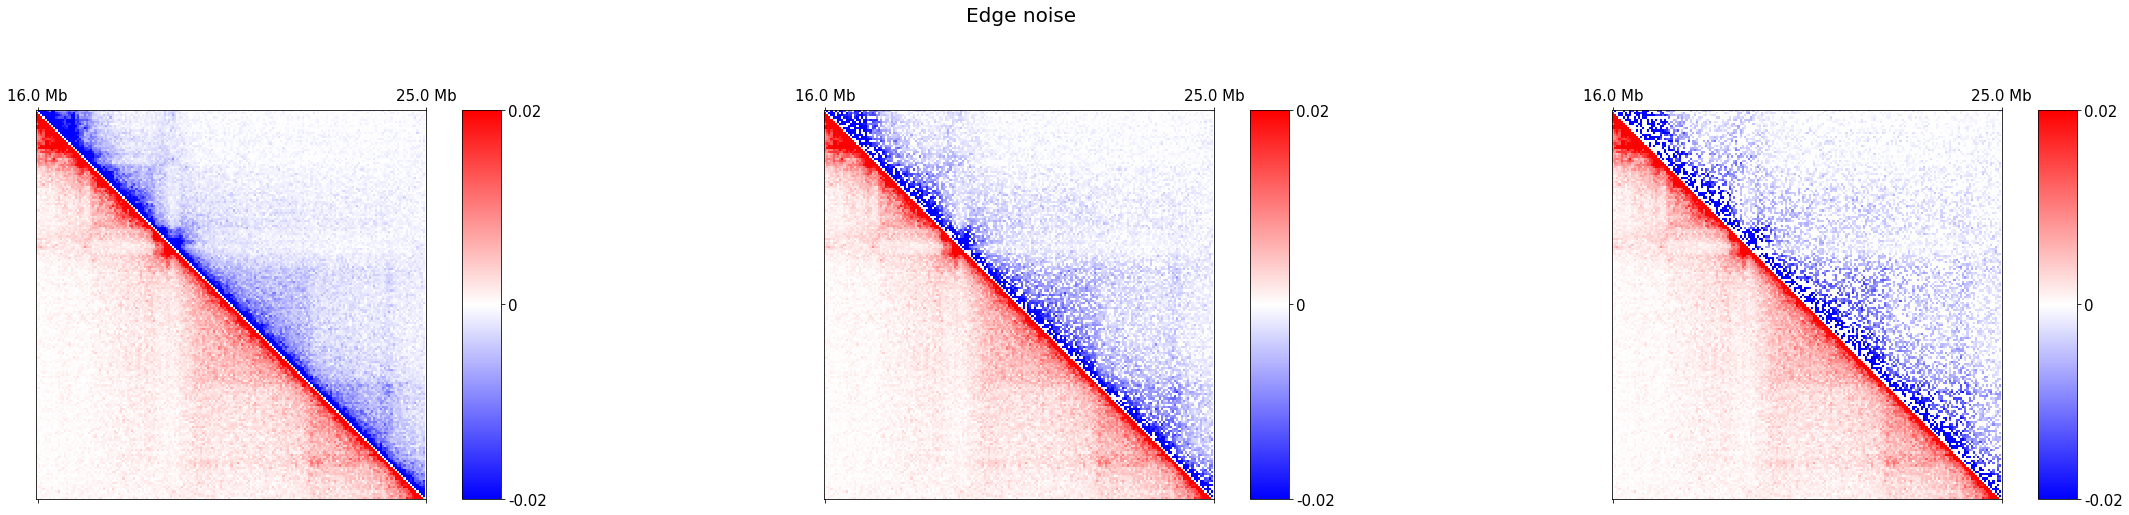

In [38]:
node_file='/ifs/scratch/oursu/paper_2017-12-20/simulations/nodes/nodes.50000.chr21.gz'
m1file='/ifs/scratch/oursu/paper_2017-12-20/simulations/EdgeNoise/data/edges/Depth_1000000.GM12878_combined.EN_0.0.NN_0.0.BN_0.a.dd_0/Depth_1000000.GM12878_combined.EN_0.0.NN_0.0.BN_0.a.dd_0.chr21.gz'
m2file='/ifs/scratch/oursu/paper_2017-12-20/simulations/EdgeNoise/data/edges/Depth_1000000.GM12878_combined.EN_0.25.NN_0.0.BN_0.a.dd_0/Depth_1000000.GM12878_combined.EN_0.25.NN_0.0.BN_0.a.dd_0.chr21.gz'
m3file='/ifs/scratch/oursu/paper_2017-12-20/simulations/EdgeNoise/data/edges/Depth_1000000.GM12878_combined.EN_0.5.NN_0.0.BN_0.a.dd_0/Depth_1000000.GM12878_combined.EN_0.5.NN_0.0.BN_0.a.dd_0.chr21.gz'
nodes,nodes_idx,blacklist_nodes=read_nodes_from_bed(node_file,'NA')
m1=sqrtvc(construct_csr_matrix_from_data_and_nodes(m1file,nodes,blacklist_nodes,True)).toarray()
m2=sqrtvc(construct_csr_matrix_from_data_and_nodes(m2file,nodes,blacklist_nodes,True)).toarray()
m3=sqrtvc(construct_csr_matrix_from_data_and_nodes(m3file,nodes,blacklist_nodes,True)).toarray()
m2=-m2+m1.T
m3=-m3+m1.T
m1=-m1+m1.T

ms=[]
ms.append(m1[s:e,s:e])
ms.append(m2[s:e,s:e])
ms.append(m3[s:e,s:e])

#params
resolution=0.05
nticks=1
figwidth=40
figheight=8
add_to_start=s
arrangement='vertical'

rwx=0.005
plot_hic_matrices(ms,resolution,nticks,figwidth,figheight,x,s,'Edge noise',-x,x,'bwr',arrangement)

Node noise simulations
===

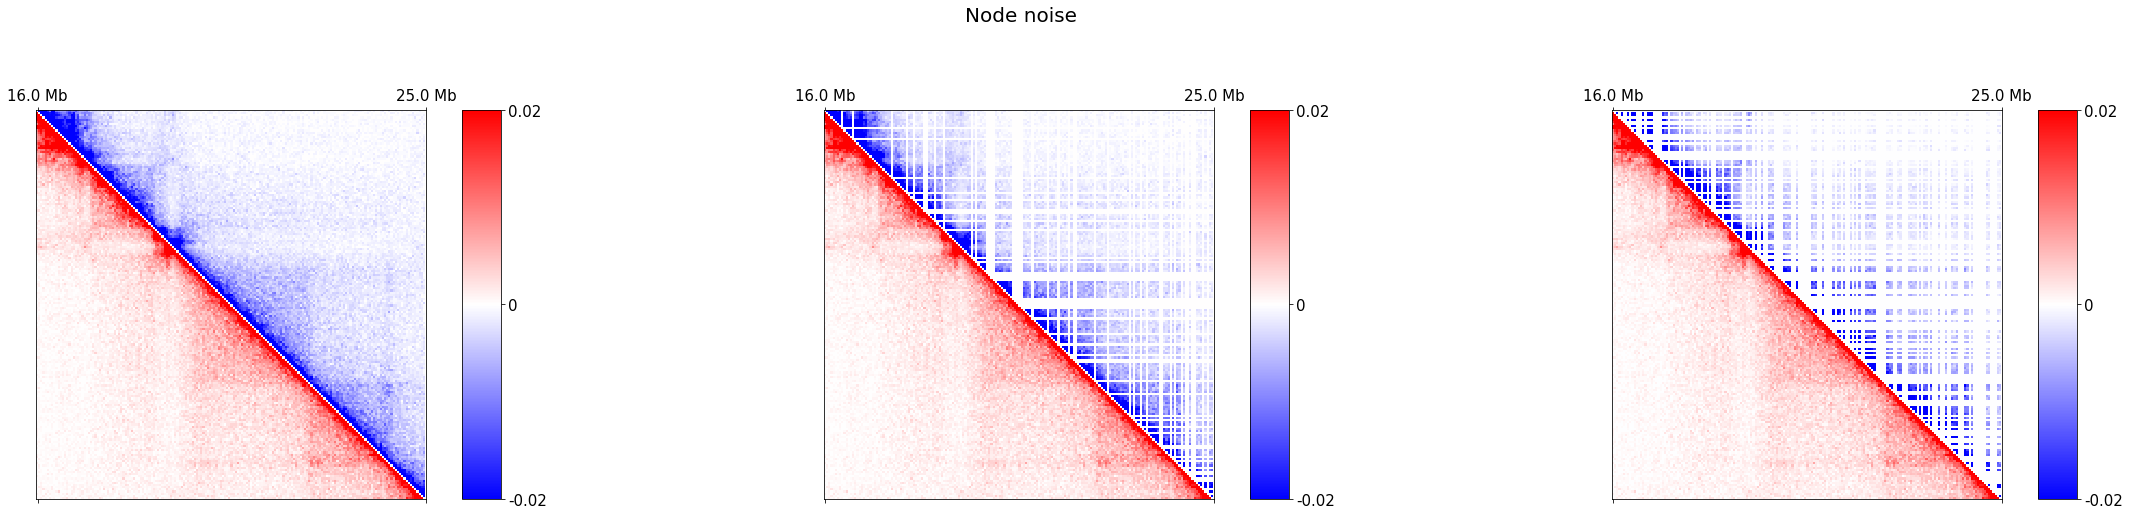

In [39]:
node_file='/ifs/scratch/oursu/paper_2017-12-20/simulations/nodes/nodes.50000.chr21.gz'
m1file='/ifs/scratch/oursu/paper_2017-12-20/simulations/NodeNoise/data/edges/Depth_1000000.GM12878_combined.EN_0.0.NN_0.0.BN_0.a.dd_0/Depth_1000000.GM12878_combined.EN_0.0.NN_0.0.BN_0.a.dd_0.chr21.gz'
m2file='/ifs/scratch/oursu/paper_2017-12-20/simulations/NodeNoise/data/edges/Depth_1000000.GM12878_combined.EN_0.0.NN_0.25.BN_0.a.dd_0/Depth_1000000.GM12878_combined.EN_0.0.NN_0.25.BN_0.a.dd_0.chr21.gz'
m3file='/ifs/scratch/oursu/paper_2017-12-20/simulations/NodeNoise/data/edges/Depth_1000000.GM12878_combined.EN_0.0.NN_0.5.BN_0.a.dd_0/Depth_1000000.GM12878_combined.EN_0.0.NN_0.5.BN_0.a.dd_0.chr21.gz'
nodes,nodes_idx,blacklist_nodes=read_nodes_from_bed(node_file,'NA')
m1=sqrtvc(construct_csr_matrix_from_data_and_nodes(m1file,nodes,blacklist_nodes,True)).toarray()
m2=sqrtvc(construct_csr_matrix_from_data_and_nodes(m2file,nodes,blacklist_nodes,True)).toarray()
m3=sqrtvc(construct_csr_matrix_from_data_and_nodes(m3file,nodes,blacklist_nodes,True)).toarray()
m2=-m2+m1.T
m3=-m3+m1.T
m1=-m1+m1.T

ms=[]
ms.append(m1[s:e,s:e])
ms.append(m2[s:e,s:e])
ms.append(m3[s:e,s:e])

#params
resolution=0.05
nticks=1

add_to_start=s
arrangement='vertical'

rwx=0.005
plot_hic_matrices(ms,resolution,nticks,figwidth,figheight,x,s,'Node noise',-x,x,'bwr',arrangement)

Domain boundary noise
====

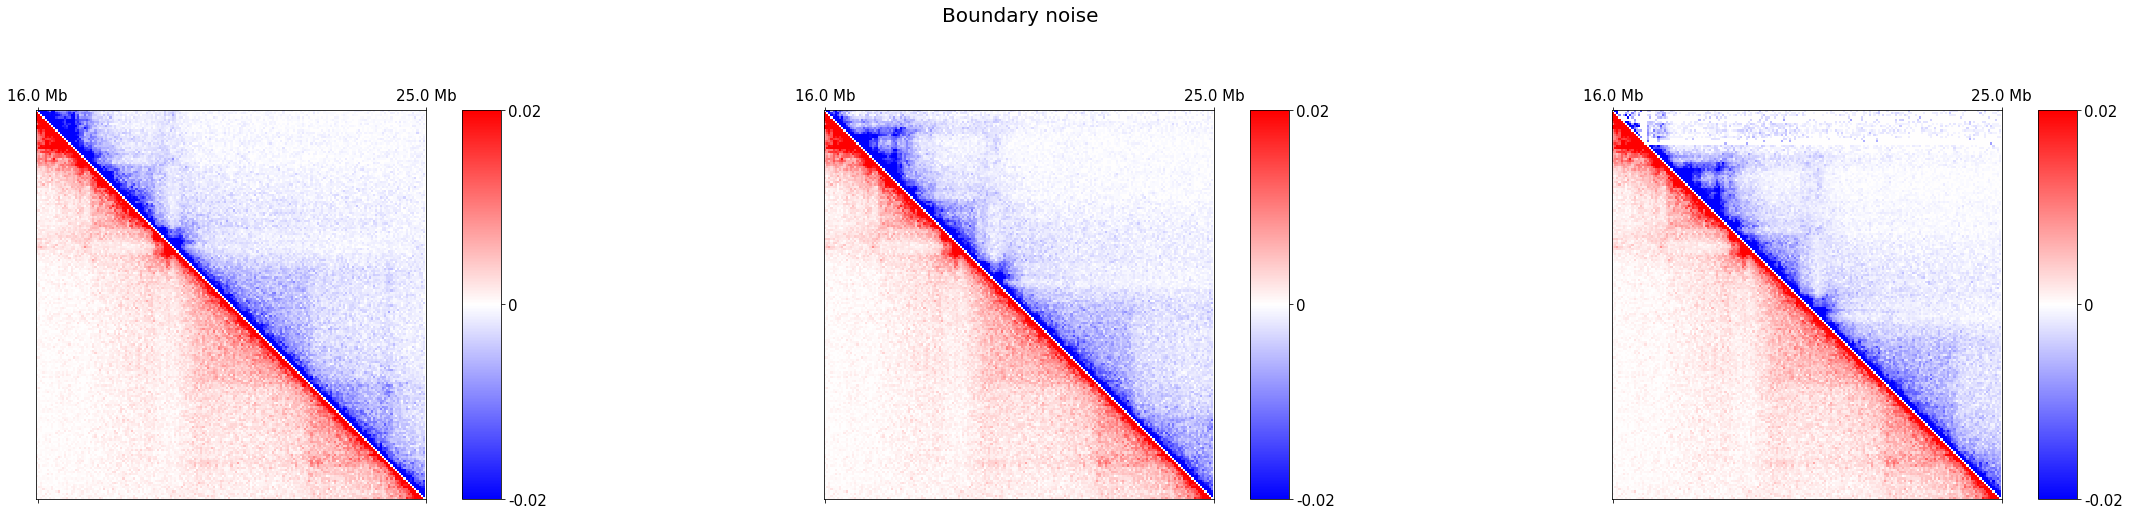

In [40]:
node_file='/ifs/scratch/oursu/paper_2017-12-20/simulations/nodes/nodes.50000.chr21.gz'
m1file='/ifs/scratch/oursu/paper_2017-12-20/simulations/BoundaryNoise/data/edges/Depth_1000000.GM12878_combined.EN_0.0.NN_0.0.BN_0.a.dd_0/Depth_1000000.GM12878_combined.EN_0.0.NN_0.0.BN_0.a.dd_0.chr21.gz'
m2file='/ifs/scratch/oursu/paper_2017-12-20/simulations/BoundaryNoise/data/edges/Depth_1000000.GM12878_combined.EN_0.0.NN_0.0.BN_16.a.dd_0/Depth_1000000.GM12878_combined.EN_0.0.NN_0.0.BN_16.a.dd_0.chr21.gz'
m3file='/ifs/scratch/oursu/paper_2017-12-20/simulations/BoundaryNoise/data/edges/Depth_1000000.GM12878_combined.EN_0.0.NN_0.0.BN_32.a.dd_0/Depth_1000000.GM12878_combined.EN_0.0.NN_0.0.BN_32.a.dd_0.chr21.gz'
nodes,nodes_idx,blacklist_nodes=read_nodes_from_bed(node_file,'NA')
m1=sqrtvc(construct_csr_matrix_from_data_and_nodes(m1file,nodes,blacklist_nodes,True)).toarray()
m2=sqrtvc(construct_csr_matrix_from_data_and_nodes(m2file,nodes,blacklist_nodes,True)).toarray()
m3=sqrtvc(construct_csr_matrix_from_data_and_nodes(m3file,nodes,blacklist_nodes,True)).toarray()
m2=-m2+m1.T
m3=-m3+m1.T
m1=-m1+m1.T

ms=[]
ms.append(m1[s:e,s:e])
ms.append(m2[s:e,s:e])
ms.append(m3[s:e,s:e])

#params
resolution=0.05
nticks=1
add_to_start=s
arrangement='vertical'

rwx=0.005
plot_hic_matrices(ms,resolution,nticks,figwidth,figheight,x,s,'Boundary noise',-x,x,'bwr',arrangement)

Bioreps vs nonreps
==

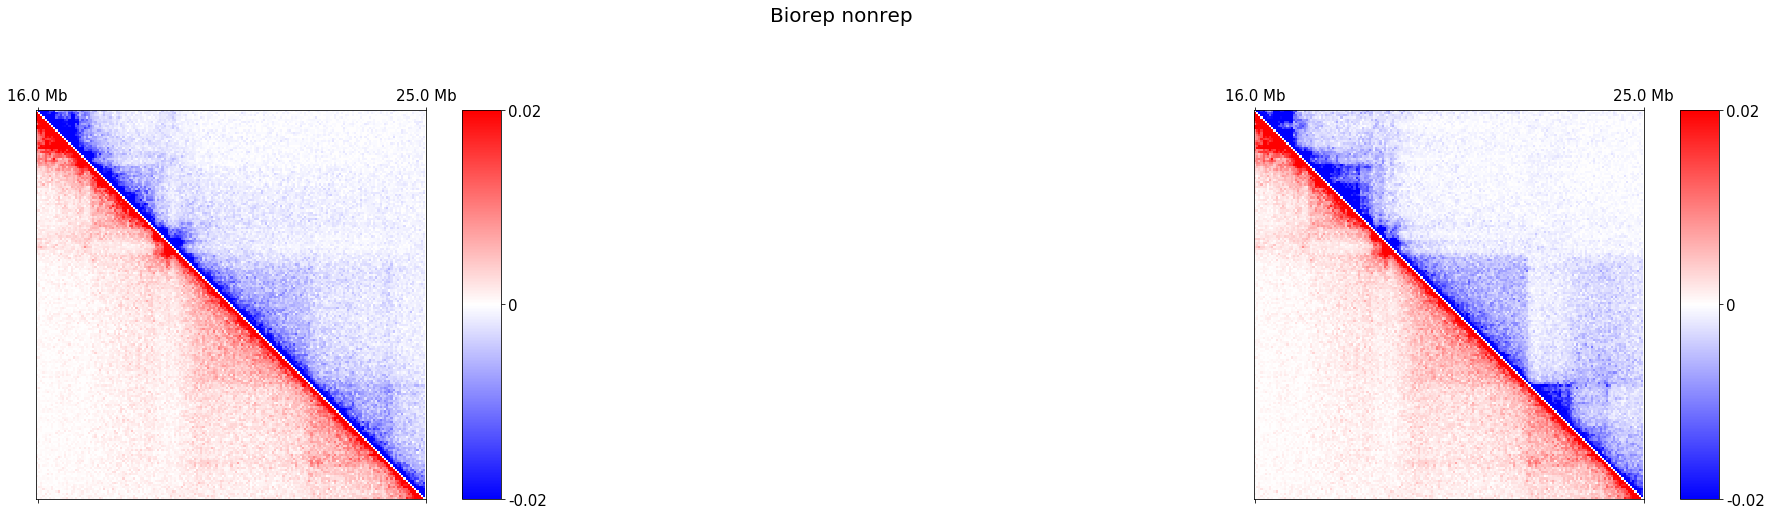

In [41]:
node_file='/ifs/scratch/oursu/paper_2017-12-20/simulations/nodes/nodes.50000.chr21.gz'
m1file='/ifs/scratch/oursu/paper_2017-12-20/simulations/BoundaryNoise/data/edges/Depth_1000000.GM12878_combined.EN_0.0.NN_0.0.BN_0.a.dd_0/Depth_1000000.GM12878_combined.EN_0.0.NN_0.0.BN_0.a.dd_0.chr21.gz'
m2file='/ifs/scratch/oursu/paper_2017-12-20/simulations/BoundaryNoise/data/edges/Depth_1000000.GM12878_combined.EN_0.0.NN_0.0.BN_0.b.dd_0/Depth_1000000.GM12878_combined.EN_0.0.NN_0.0.BN_0.b.dd_0.chr21.gz'
m3file='/ifs/scratch/oursu/paper_2017-12-20/simulations/BoundaryNoise/data/edges/Depth_1000000.IMR90.EN_0.0.NN_0.0.BN_0.a.dd_0/Depth_1000000.IMR90.EN_0.0.NN_0.0.BN_0.a.dd_0.chr21.gz'
nodes,nodes_idx,blacklist_nodes=read_nodes_from_bed(node_file,'NA')
m1=sqrtvc(construct_csr_matrix_from_data_and_nodes(m1file,nodes,blacklist_nodes,True)).toarray()
m2=sqrtvc(construct_csr_matrix_from_data_and_nodes(m2file,nodes,blacklist_nodes,True)).toarray()
m3=sqrtvc(construct_csr_matrix_from_data_and_nodes(m3file,nodes,blacklist_nodes,True)).toarray()
m2=-m2+m1.T
m3=-m3+m1.T
m1=-m1+m1.T

ms=[]
#ms.append(m1[s:e,s:e])
ms.append(m2[s:e,s:e])
ms.append(m3[s:e,s:e])

#params
resolution=0.05
nticks=1
add_to_start=s
arrangement='vertical'

rwx=0.005
plot_hic_matrices(ms,resolution,nticks,figwidth,figheight,x,s,'Biorep nonrep',-x,x,'bwr',arrangement)

Diff distance dependence
==

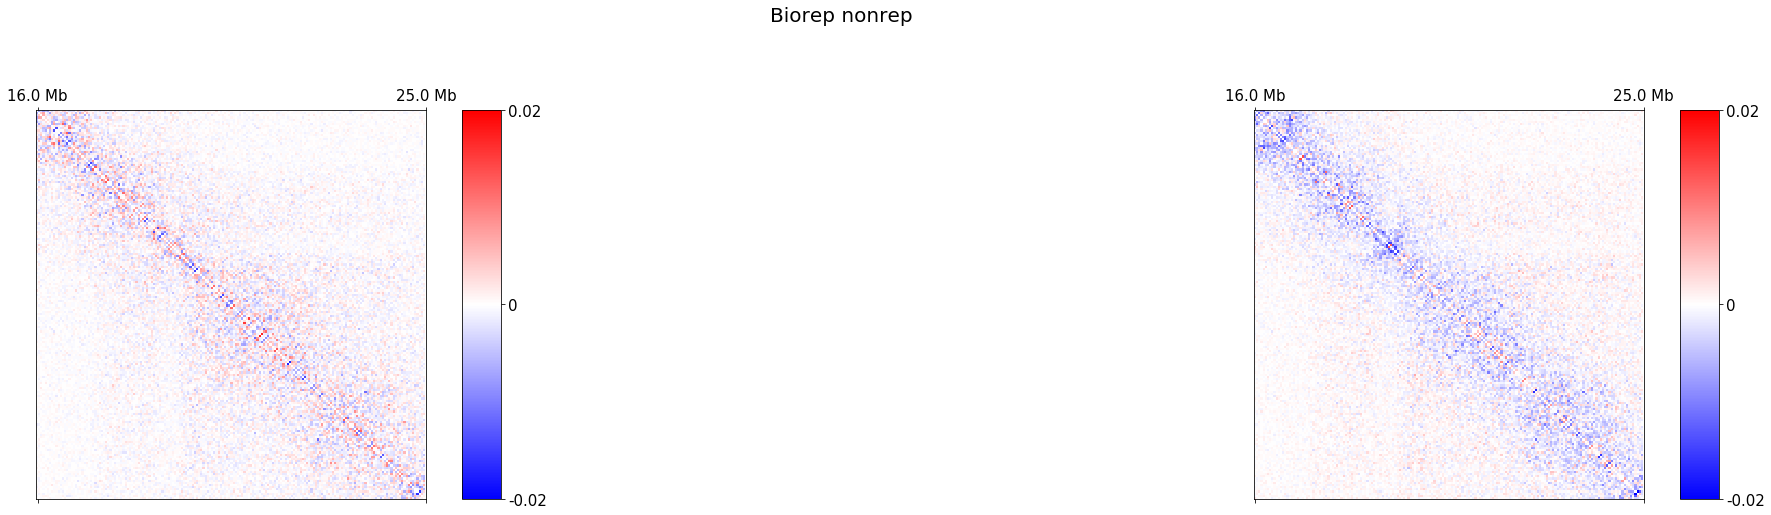

In [53]:
node_file='/ifs/scratch/oursu/paper_2017-12-20/simulations/nodes/nodes.50000.chr21.gz'
m1file='/ifs/scratch/oursu/paper_2017-12-20/simulations/DistanceDependence/data/edges/Depth_1000000.GM12878_combined.EN_0.0.NN_0.0.BN_0.a.dd_5/Depth_1000000.GM12878_combined.EN_0.0.NN_0.0.BN_0.a.dd_5.chr21.gz'
m2file='/ifs/scratch/oursu/paper_2017-12-20/simulations/DistanceDependence/data/edges/Depth_1000000.GM12878_combined.EN_0.0.NN_0.0.BN_0.b.dd_5/Depth_1000000.GM12878_combined.EN_0.0.NN_0.0.BN_0.b.dd_5.chr21.gz'
m3file='/ifs/scratch/oursu/paper_2017-12-20/simulations/DistanceDependence/data/edges/Depth_1000000.GM12878_combined.EN_0.0.NN_0.0.BN_0.a.dd_2/Depth_1000000.GM12878_combined.EN_0.0.NN_0.0.BN_0.a.dd_2.chr21.gz'
nodes,nodes_idx,blacklist_nodes=read_nodes_from_bed(node_file,'NA')
m1=sqrtvc(construct_csr_matrix_from_data_and_nodes(m1file,nodes,blacklist_nodes,True)).toarray()
m2=sqrtvc(construct_csr_matrix_from_data_and_nodes(m2file,nodes,blacklist_nodes,True)).toarray()
m3=sqrtvc(construct_csr_matrix_from_data_and_nodes(m3file,nodes,blacklist_nodes,True)).toarray()
m2=m2+m2.T
m1=m1+m1.T
m3=m3+m3.T


ms=[]
#ms.append(m1[s:e,s:e])
ms.append(m2[s:e,s:e]-m1[s:e,s:e])
ms.append(m3[s:e,s:e]-m1[s:e,s:e])

#params
resolution=0.05
nticks=1
add_to_start=s
arrangement='vertical'

rwx=0.005
y=0.02
plot_hic_matrices(ms,resolution,nticks,figwidth,figheight,x,s,'Biorep nonrep',-y,y,'bwr',arrangement)

Different sequencing depth
==

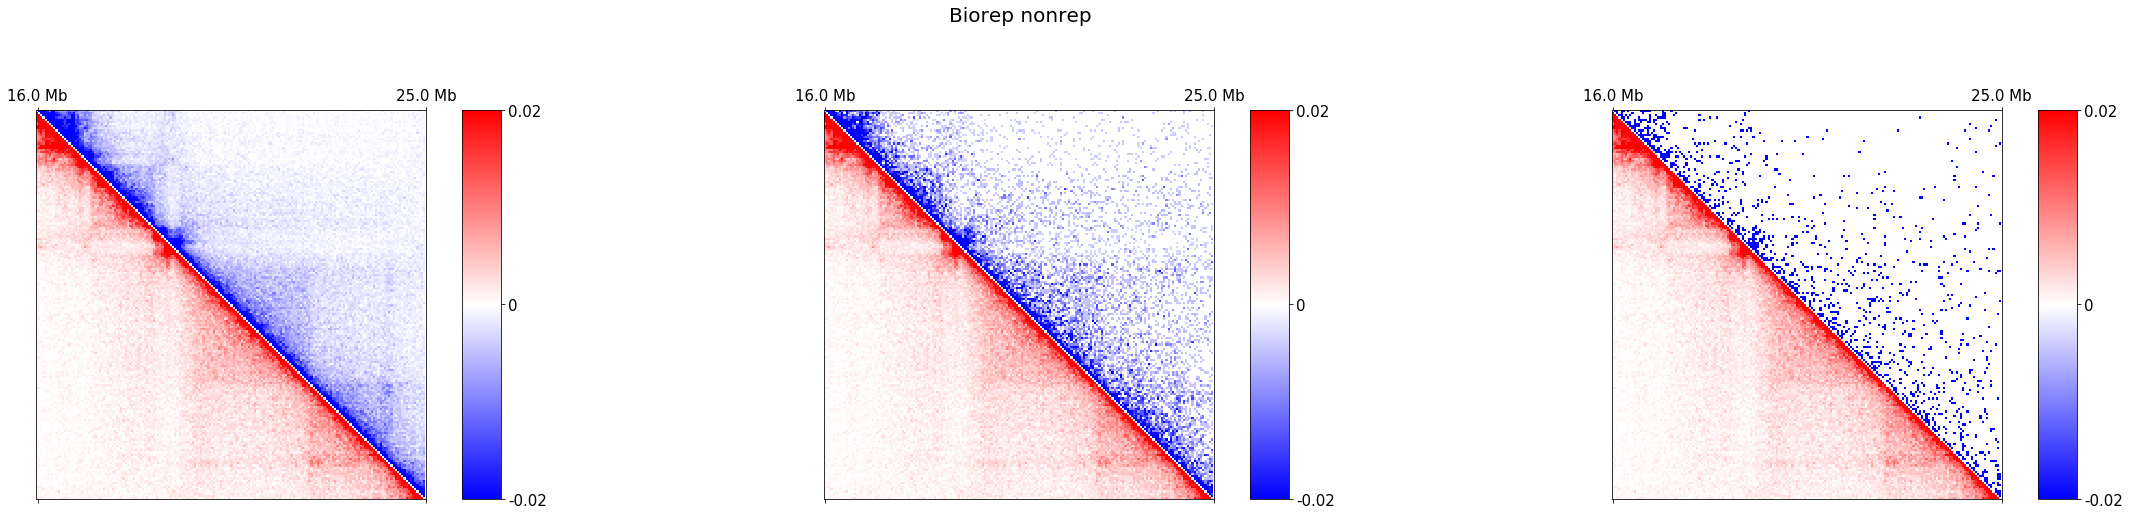

In [44]:
node_file='/ifs/scratch/oursu/paper_2017-12-20/simulations/nodes/nodes.50000.chr21.gz'
m1file='/ifs/scratch/oursu/paper_2017-12-20/simulations/BoundaryNoise/data/edges/Depth_1000000.GM12878_combined.EN_0.0.NN_0.0.BN_0.a.dd_0/Depth_1000000.GM12878_combined.EN_0.0.NN_0.0.BN_0.a.dd_0.chr21.gz'
m2file='/ifs/scratch/oursu/paper_2017-12-20/simulations/BoundaryNoise/data/edges/Depth_100000.GM12878_combined.EN_0.0.NN_0.0.BN_0.a.dd_0/Depth_100000.GM12878_combined.EN_0.0.NN_0.0.BN_0.a.dd_0.chr21.gz'
m3file='/ifs/scratch/oursu/paper_2017-12-20/simulations/BoundaryNoise/data/edges/Depth_10000.GM12878_combined.EN_0.0.NN_0.0.BN_0.a.dd_0/Depth_10000.GM12878_combined.EN_0.0.NN_0.0.BN_0.a.dd_0.chr21.gz'
nodes,nodes_idx,blacklist_nodes=read_nodes_from_bed(node_file,'NA')
m1=sqrtvc(construct_csr_matrix_from_data_and_nodes(m1file,nodes,blacklist_nodes,True)).toarray()
m2=sqrtvc(construct_csr_matrix_from_data_and_nodes(m2file,nodes,blacklist_nodes,True)).toarray()
m3=sqrtvc(construct_csr_matrix_from_data_and_nodes(m3file,nodes,blacklist_nodes,True)).toarray()
m2=-m2+m1.T
m3=-m3+m1.T
m1=-m1+m1.T

ms=[]
ms.append(m1[s:e,s:e])
ms.append(m2[s:e,s:e])
ms.append(m3[s:e,s:e])

#params
resolution=0.05
nticks=1
add_to_start=s
arrangement='vertical'

rwx=0.005
plot_hic_matrices(ms,resolution,nticks,figwidth,figheight,x,s,'Biorep nonrep',-x,x,'bwr',arrangement)